<a href="https://colab.research.google.com/github/rimchristian/Hotel-Reservation-ML-Model/blob/main/hotelbooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Description**

### **Task**
The aim is to predict if the customer is going to honor the reservation or cancel it?

###**Import Libraries**

In [1]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatPlotLib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

## Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosting Algorithm 
from sklearn.ensemble import GradientBoostingClassifier


## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay, plot_confusion_matrix, roc_auc_score

from sklearn import metrics
## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

### **Functions**

In [2]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize)
  plt.show()

# **Load and Inspect the Data**

In [4]:
filename = '/content/hotelreservations.csv'
df = pd.read_csv(filename)

In [5]:
# display the first 5 rows
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [6]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 36275 rows, and 19 columns.
The rows represent 36275 observations, and the columns represent 18 features and 1 target variable.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

### **Inspecting**

In [8]:
# display the descriptive statistics for the numeric columns
df.describe(include='number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [9]:
# display the descriptive statistics for the categorical columns
df.describe(include='object')

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
count,36275,36275,36275,36275,36275
unique,36275,4,7,5,2
top,INN00001,Meal Plan 1,Room_Type 1,Online,Not_Canceled
freq,1,27835,28130,23214,24390


# **Clean the Data**

## **Remove Unnecessary Columns**

In [ ]:
# drop columns
#df = df.drop(columns=['Booking_ID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

## **Remove Unnecessary Rows**

In [10]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


## **Inspect Column Names for Errors**

In [11]:
df.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

## **Inspect Values for Errors**

In [12]:
df.describe(include='number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## **Missing Values**

In [13]:
# Display the total number of missing values 
print(f'There are {df.isna().sum().sum()} missing values.')

There are 0 missing values.


# **Visualization**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

### **Univariate Visuals**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Class')

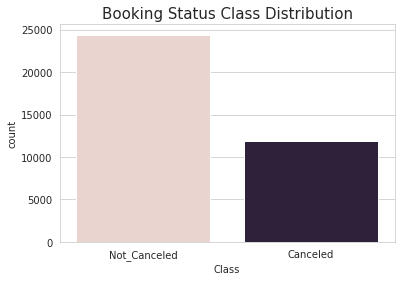

In [14]:
sns.set_style("whitegrid")
ax = sns.countplot(df['booking_status'], palette=sns.cubehelix_palette(2))
plt.title('Booking Status Class Distribution', fontsize=15)
plt.xlabel(xlabel='Class')

The two classes were not distributed balanced so the data may be imbalanced. 1 for Canceled and 0 for Not Canceled. 

In [15]:
df['booking_status'].value_counts()
df['booking_status'].replace({'Canceled':1,'Not_Canceled':0}, inplace=True)
df['booking_status'].value_counts()


0    24390
1    11885
Name: booking_status, dtype: int64

Text(0.5, 1.0, 'Number of Adults and Children')

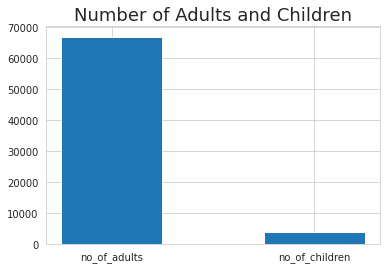

In [16]:
fig, ax = plt.subplots()
ax.bar(np.arange(2), [df['no_of_adults'].sum(), df['no_of_children'].sum()], width=0.5)
plt.xticks(np.arange(2), ('no_of_adults','no_of_children'))
plt.title('Number of Adults and Children', fontsize=18)

More adults has booked a room than children. 

Room Type 6 is the most expensive one, followed by Room Type 7.  Room Type 2 or Type 3 is the cheapest one. 

Text(0.5, 1.0, 'Booking Distribution by the days of Months')

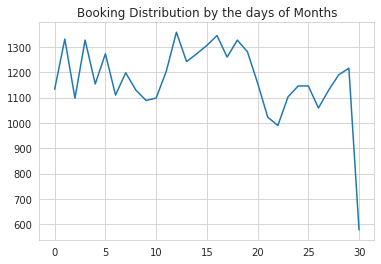

In [17]:
plt.plot(df['arrival_date'].value_counts().sort_index().values)
plt.title('Booking Distribution by the days of Months')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Bookings by Year')

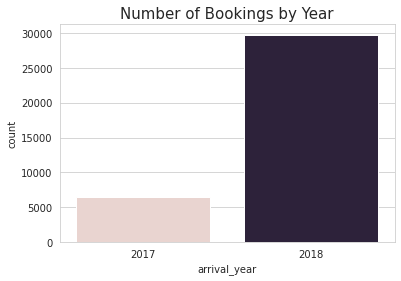

In [18]:
ax = sns.countplot(df['arrival_year'], palette=sns.cubehelix_palette(2))
plt.title('Number of Bookings by Year', fontsize=15)

- Our samples are mostly in 2018. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Cancelation Situation by Months')

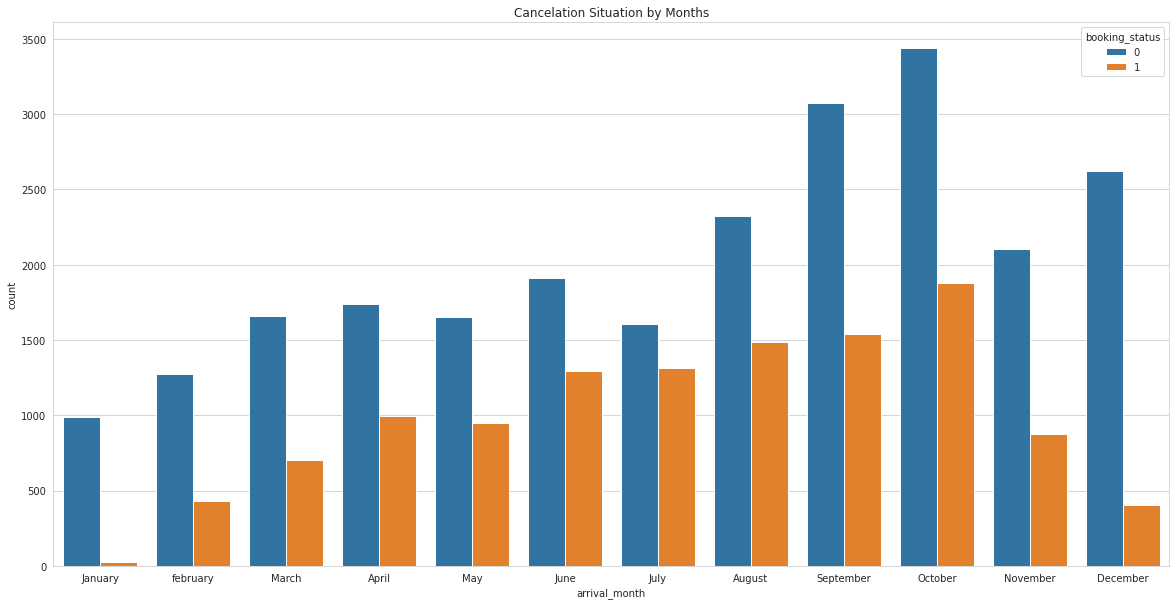

In [39]:
plt.figure(figsize=(20,10))
sns.countplot(df["arrival_month"], hue=df["booking_status"])
plt.xticks(np.arange(0,12),["January", "february", "March", "April","May","June",
"July","August","September","October","November","December"])
plt.title("Cancelation Situation by Months")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Special Request - Cancellation')

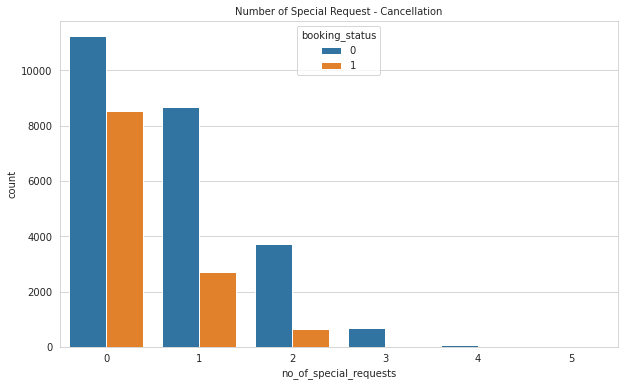

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(df['no_of_special_requests'], hue=df['booking_status'])
plt.title('Number of Special Request - Cancellation', fontsize=10)

This chart shows that the cancelation rate is higher for the guests who didn have a special request. 



In [25]:
df.groupby('repeated_guest')['booking_status'].value_counts()

repeated_guest  booking_status
0               0                 23476
                1                 11869
1               0                   914
                1                    16
Name: booking_status, dtype: int64

- The cancelation rate is higher for not repeated guests compared to repeated ones. 
- Most of the repeated guests didn't cancel. A good sign.  

### **Identifying Outliers**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lead Time by Cancellation')

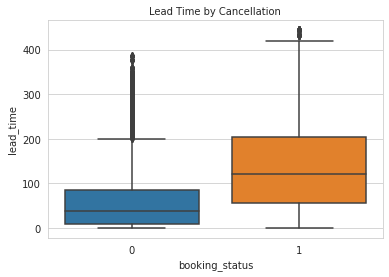

In [26]:
# deploying a boxplot for the booking status
sns.boxplot(df['booking_status'], df['lead_time'])
plt.title('Lead Time by Cancellation', fontsize=10)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lead Time by Cancellation')

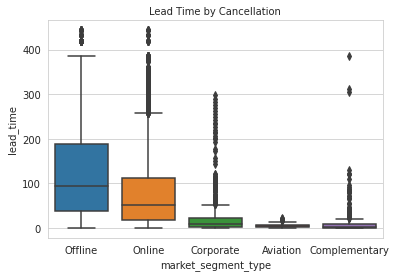

In [27]:
# deploying a boxplot
sns.boxplot(df['market_segment_type'], df['lead_time'])
plt.title('Lead Time by Cancellation', fontsize=10)

This boxplot shows that the offline has the most lead time. The lead time is the period between the booking time and arrival date. More people reserve in person than online. Although, there are more outliers at higher counts for the online box. Could be a good insight. 

There are outliers in this data. 

I can also say that as the lead time increases, the possibiity of canceling increases as well. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Adults reserving on week days')

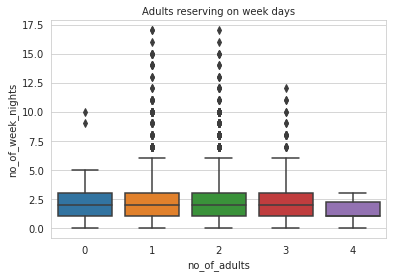

In [28]:
# deploying a boxplot
sns.boxplot(df['no_of_adults'], df['no_of_week_nights'])
plt.title('Adults reserving on week days', fontsize=10)


Shows the count of the number of week nights for each party. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Children')

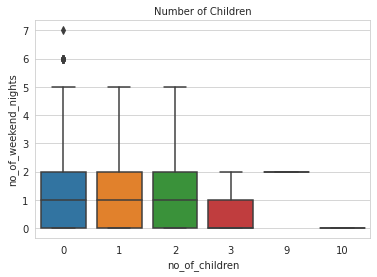

In [29]:
# deploying a boxplot on children and number of weekened nights
sns.boxplot(df['no_of_children'], df['no_of_weekend_nights'])
plt.title('Number of Children', fontsize=10)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Parking Space Reservation')

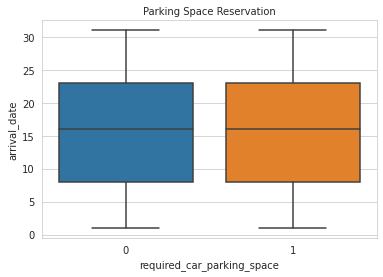

In [30]:
# deploying a boxplot on parking space and arrival date
sns.boxplot(df['required_car_parking_space'], df['arrival_date'])
plt.title('Parking Space Reservation', fontsize=10)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Repeated guests reserving on weekdays')

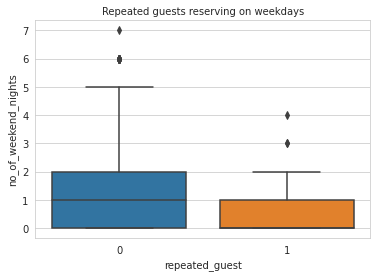

In [ ]:
# deploying a boxplot on repeated guests and number of weekened nights
sns.boxplot(df['repeated_guest'], df['no_of_weekend_nights'])
plt.title('Repeated guests reserving on weekdays', fontsize=10)

### **Finding Correlations**

In [31]:
# identifying the correlations
df.corr()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
no_of_adults,1.000000,-0.019787,0.103316,0.105622,0.011429,0.097287,0.076719,0.021841,0.026338,-0.192277,-0.047426,-0.119166,0.296886,0.189401,0.086920
no_of_children,-0.019787,1.000000,0.029478,0.024398,0.034244,-0.047091,0.045983,-0.003076,0.025482,-0.036348,-0.016390,-0.021189,0.337728,0.124486,0.033078
no_of_weekend_nights,0.103316,0.029478,1.000000,0.179577,-0.031111,0.046595,0.055357,-0.009894,0.027304,-0.067107,-0.020690,-0.026312,-0.004525,0.060593,0.061563
no_of_week_nights,0.105622,0.024398,0.179577,1.000000,-0.048784,0.149650,0.032672,0.037376,-0.009305,-0.099764,-0.030080,-0.049344,0.022753,0.045994,0.092996
required_car_parking_space,0.011429,0.034244,-0.031111,-0.048784,1.000000,-0.066445,0.015684,-0.015505,-0.000037,0.110909,0.027106,0.063810,0.061304,0.087922,-0.086185
lead_time,0.097287,-0.047091,0.046595,0.149650,-0.066445,1.000000,0.143439,0.136814,0.006479,-0.135984,-0.045723,-0.078137,-0.062596,-0.101645,0.438538
arrival_year,0.076719,0.045983,0.055357,0.032672,0.015684,0.143439,1.000000,-0.339689,0.018849,-0.018175,0.003919,0.026422,0.178605,0.053205,0.179529
arrival_month,0.021841,-0.003076,-0.009894,0.037376,-0.015505,0.136814,-0.339689,1.000000,-0.042780,0.000341,-0.038615,-0.010718,0.054423,0.110552,-0.011233
arrival_date,0.026338,0.025482,0.027304,-0.009305,-0.000037,0.006479,0.018849,-0.042780,1.000000,-0.015949,-0.012542,-0.001498,0.017898,0.018352,0.010629
repeated_guest,-0.192277,-0.036348,-0.067107,-0.099764,0.110909,-0.135984,-0.018175,0.000341,-0.015949,1.000000,0.390810,0.539156,-0.174900,-0.011820,-0.107287


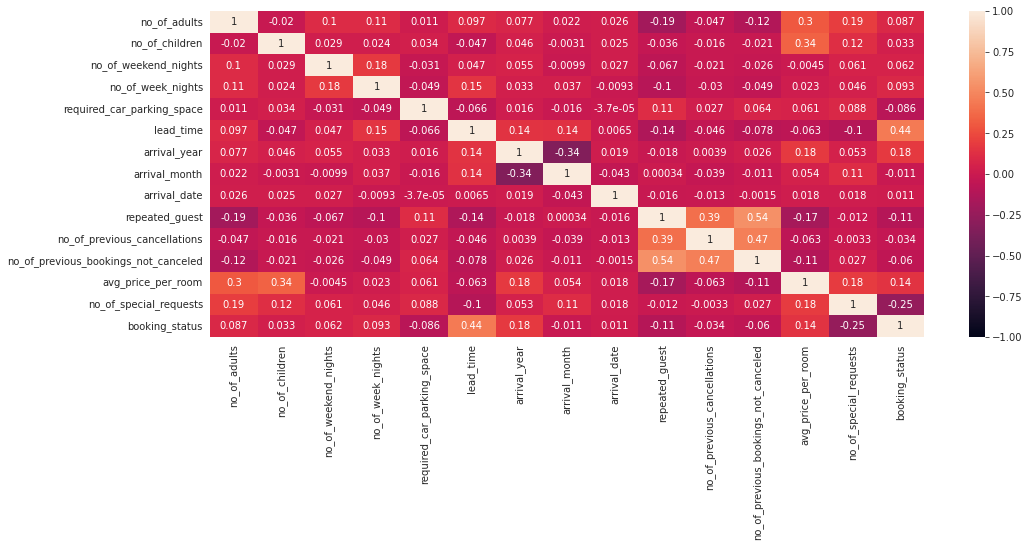

In [32]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

In [33]:
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

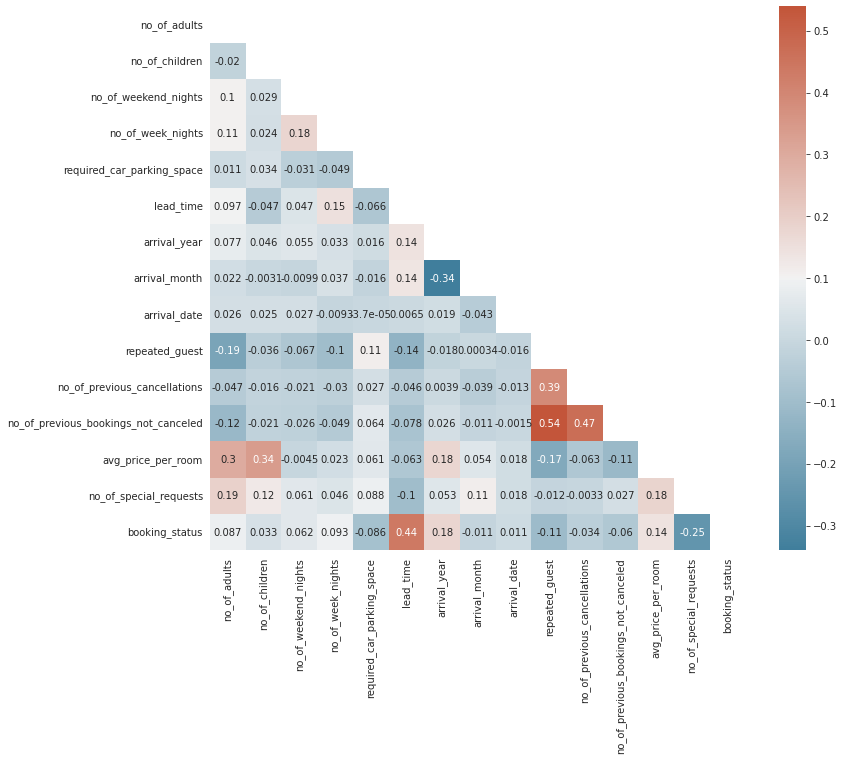

In [34]:
#Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(df.corr(), dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), annot=True, mask = mask, cmap=cmap)

Correlation Summary:
- There isn't much of a correlation between the target and the feature variables.  The booking status and the lead time had a correlation of 0.44, which is pretty moderate.
- The other important thing to note is  that there is no correlation greater than 60%. The highest was 0.54 between repeated guests and number of previous bookings not canceled.  I have a pie chart to demonstrate the cancelation chart for repeated guests. 

Text(0.5, 1.0, 'Distribution in # of days between date of booking and arrival date')

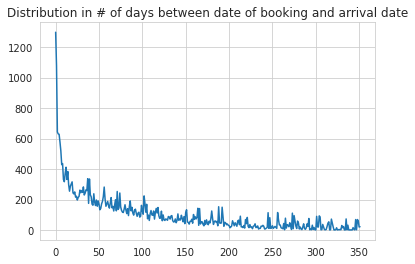

In [35]:
plt.plot(df['lead_time'].value_counts().sort_index().values)
plt.title('Distribution in # of days between date of booking and arrival date')

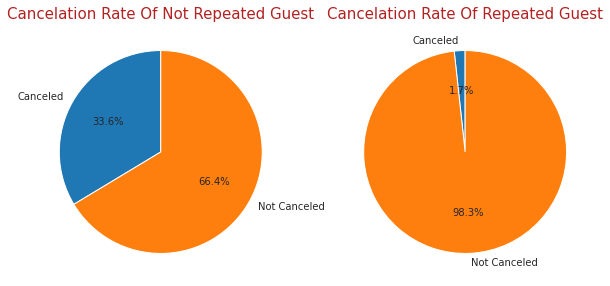

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'aspect': 'equal'})
ax[0].pie([11896,23476], labels=["Canceled","Not Canceled"], autopct='%1.1f%%', startangle=90)
ax[0].set_title("Cancelation Rate Of Not Repeated Guest",color="#b22222",fontsize=15)
ax[1].pie([16,914], labels=["Canceled","Not Canceled"], autopct='%1.1f%%', startangle=90)
ax[1].set_title("Cancelation Rate Of Repeated Guest",color="#b22222",fontsize=15);

This pie chart displays a nice visualization that shows cancellation rates for repeated guests and not repeated guests. We can see that for repeated guests, they mostly keep their reservation. For first time guests, there is a 33% cancelation rate and 66% didn't cancel. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Average Prices of Each Room Types')

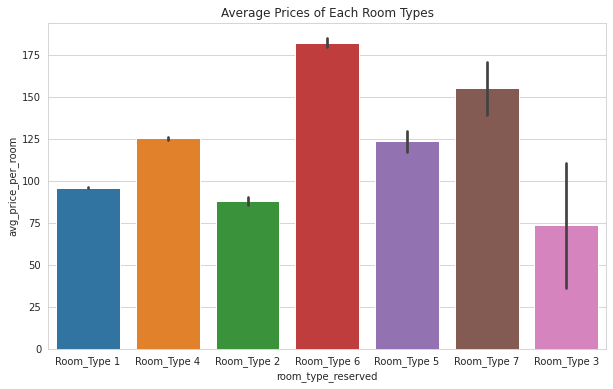

In [37]:
plt.figure(figsize=(10,6))
ax =  sns.barplot(df['room_type_reserved'], df['avg_price_per_room'])
plt.title('Average Prices of Each Room Types')

This shows the average prices for each room types.  The most expensive room was Room Type 6, $177.  Room Type 7 was also one of the popular options as wel. Room Type 3 had the lowest average price. 